In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
# read files
img_1 = cv2.imread('images/IMG-6.jpg')
img_2 = cv2.imread('images/IMG-5.jpg')
img_3 = cv2.imread('images/IMG-1.jpg')
img_4 = cv2.imread('images/IMG-9.jpg')

In [3]:
def show_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # change color channels 
    plt.imshow(image)
    plt.show()
    
def to_grayscale(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def resize(img, length, width):
    output = cv2.resize(img, (length, width), interpolation=cv2.INTER_AREA)
    return output

In [4]:
def gaussian_blur(image, mask_size, sigma):
    g_filter = []
    total = 0
    for i in range(mask_size):
        row_list = []
        for j in range(mask_size):
            x = -mask_size//2 + j + 1
            y = -mask_size//2 + i + 1
            ans = ( (1 / (2*math.pi*sigma**2)) * 
                    math.exp(-( (x**2 + y**2) / (2*sigma**2) )) )
            row_list.append(ans)
            total += ans
        g_filter.append(row_list)
    g_filter = np.array(g_filter)
    
    # normalization
    for i in range(mask_size): 
        for j in range(mask_size):
            g_filter[i][j] = g_filter[i][j] / total
            
    new_image = np.zeros(image.shape, dtype='uint8')
    
    # filtering
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            new_value = 0
            for p in range(mask_size):
                for q in range(mask_size):
                    y_index = i - mask_size//2 + p
                    x_index = j - mask_size//2 + q
                    if y_index < 0 or x_index < 0: pixel_value = 0
                    elif (y_index >= image.shape[0] 
                          or x_index >= image.shape[1]): pixel_value = 0
                    else: pixel_value = image[y_index][x_index]
                    new_value += pixel_value * g_filter[q][p]
            new_image[i][j] = new_value
    return new_image 

In [5]:
def sobel_filter(img):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    mask_size = 3
    
    new_img = np.zeros(img.shape)
    intensity_x = np.zeros(img.shape)
    intensity_y = np.zeros(img.shape)
    
    # filtering
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_vx = 0
            new_vy = 0
            for p in range(mask_size):
                for q in range(mask_size):
                    y_index = i - mask_size//2 + p
                    x_index = j - mask_size//2 + q
                    if y_index < 0 or x_index < 0: pixel_value = 0
                    elif (y_index >= img.shape[0] 
                          or x_index >= img.shape[1]): pixel_value = 0
                    else: pixel_value = img[y_index][x_index]
                        
                    new_vx += pixel_value * kernel_x[q][p]
                    new_vy += pixel_value * kernel_y[q][p]
            
            intensity_x[i][j] = new_vx
            intensity_y[i][j] = new_vy
            new_v = math.sqrt( new_vx**2 + new_vy**2 )
            new_img[i][j] = new_v
    theta = np.arctan2(intensity_y, intensity_x) * 180 / np.pi
    theta[theta < 0] += 180
    
    return new_img, theta

In [6]:
def non_max_supression(img, angle):
    new_image = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            try: 
                if (0 <= angle[i][j] < 22.5) or (157.5 <= angle[i][j] <= 180):
                    pixel_1 = img[i+1][j]
                    pixel_2 = img[i-1][j]
                
                elif (22.5 <= angle[i][j] < 67.5):
                    pixel_1 = img[i-1][j-1]
                    pixel_2 = img[i+1][j+1]
                
                elif (67.5 <= angle[i][j] < 112.5):
                    pixel_1 = img[i][j+1]
                    pixel_2 = img[i][j-1]
                
                elif (112.5 <= angle[i][j] < 157.5):
                    pixel_1 = img[i+1][j-1]
                    pixel_2 = img[i-1][j+1]

                if img[i][j] >= pixel_1 and img[i][j] >= pixel_2:
                    new_image[i][j] = img[i][j]
                else: new_image[i][j] = 0
                    
            except IndexError: pass
                
    return new_image

In [7]:
def double_threshold(img, angle, low_threshold, high_threshold):
    new_img = np.zeros(img.shape)
    strong = 255
    weak = 100
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] >= high_threshold: new_img[i][j] = strong
            elif img[i][j] < low_threshold: new_img[i][j] = 0
            else: new_img[i][j] = weak
                
    tested = np.zeros(img.shape)
    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            
            if tested[i][j] == 0 and new_img[i][j] == strong: 
                tested[i][j] = 1
                queue = [[i, j]]
                
                while (len(queue) != 0):
                    center_index = queue[0]
                    queue.pop(0)
                    p = center_index[0]
                    q = center_index[1]
                    try: 
                        neighbors = [[p+1, q-1], [p+1, q], [p+1, q+1],
                                    [p, q-1], [p, q+1],
                                    [p-1, q-1], [p-1, q], [p-1, q+1]]

                        for index in range(len(neighbors)):
                            r = neighbors[index][0]
                            s = neighbors[index][1]

                            if new_img[r][s] == weak:
                                tested[r][s] = 1
                                new_img[r][s] = strong
                                queue.append([r, s])

                    except IndexError: pass
                    
                    
    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            if new_img[i][j] != strong:
                new_img[i][j] = 0
  
    return new_img.astype('uint8')

In [8]:
# canny edge detector
def canny_edge_detector(img, low_threshold, high_threshold):
    grad_intensity, angle = sobel_filter(img)
    out = non_max_supression(grad_intensity, angle)
    result = double_threshold(out, angle, low_threshold, high_threshold)
    return result

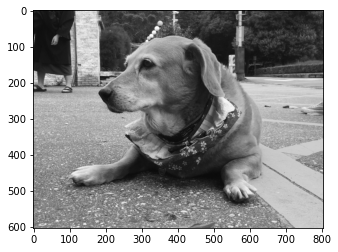

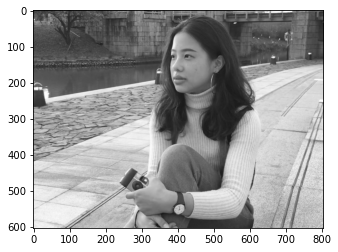

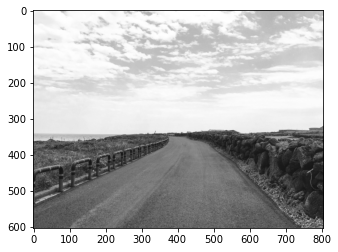

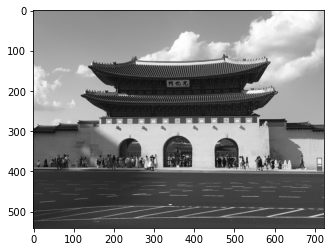

In [9]:
img_1g = to_grayscale(resize(img_1, int(img_1.shape[1]/5), int(img_1.shape[0]/5)))
show_image(img_1g)
cv2.imwrite('result_images/IMG-1-g.jpg', img_1g)
img_2g = to_grayscale(resize(img_2, int(img_2.shape[1]/5), int(img_2.shape[0]/5)))
show_image(img_2g)
cv2.imwrite('result_images/IMG-2-g.jpg', img_2g)
img_3g = to_grayscale(resize(img_3, int(img_3.shape[1]/5), int(img_3.shape[0]/5)))
show_image(img_3g)
cv2.imwrite('result_images/IMG-3-g.jpg', img_3g)
img_4g = to_grayscale(resize(img_4, int(img_4.shape[1]/5), int(img_4.shape[0]/5)))
show_image(img_4g)
cv2.imwrite('result_images/IMG-4-g.jpg', img_4g)

img_list = [img_1g, img_2g, img_3g, img_4g]

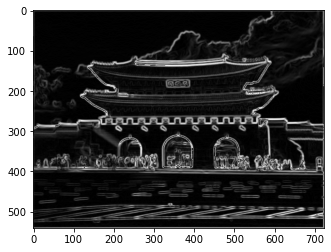

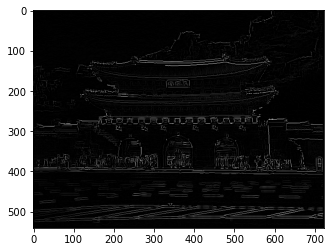

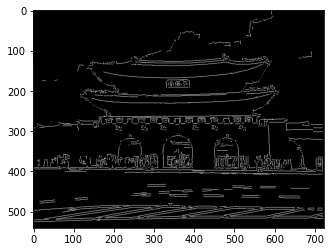

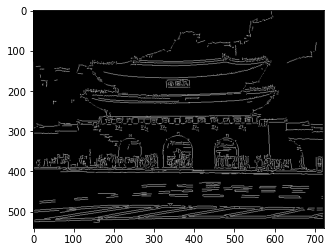

True

In [14]:
blurred = gaussian_blur(img_list[3], 5, 3)
cv2.imwrite('result_images/IMG-4-smoothed.jpg', blurred)

grad_intensity, angle = sobel_filter(blurred)
show_image(grad_intensity.astype('uint8'))
cv2.imwrite('result_images/IMG-4-grad-intensity.jpg', grad_intensity)

out = non_max_supression(grad_intensity, angle)
show_image(out.astype('uint8'))
cv2.imwrite('result_images/IMG-4-non-max-sup.jpg', out)

result_1 = double_threshold(out, angle, 40 ,80)
result_2 = double_threshold(out, angle, 30 ,60)
show_image(result_1)
show_image(result_2)
cv2.imwrite('result_images/IMG-4-canny-40-80.jpg', result_1)
cv2.imwrite('result_images/IMG-4-canny-30-60.jpg', result_2)

In [22]:
canny_2.max()

255

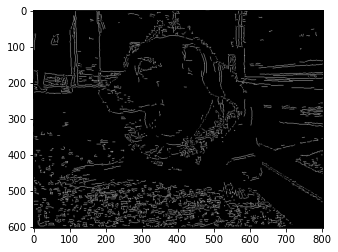

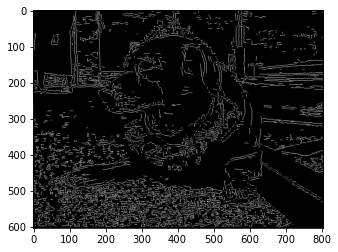

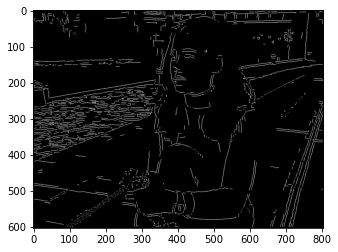

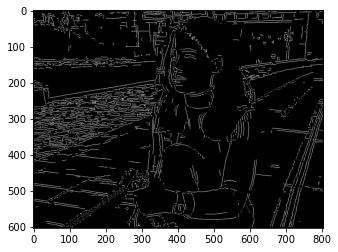

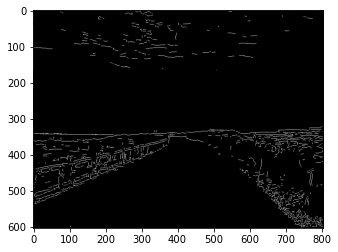

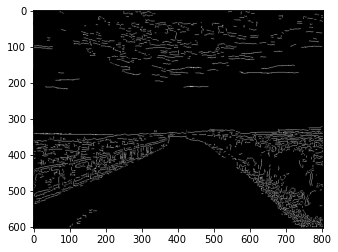

In [11]:
for i in range(len(img_list) - 1):
    blurred = gaussian_blur(img_list[i], 5, 3)
    canny_1 = canny_edge_detector(blurred, 40, 80)
    canny_2 = canny_edge_detector(blurred, 30, 60)
    show_image(canny_1)
    show_image(canny_2)
    cv2.imwrite(f'result_images/IMG-{i+1}-canny-40-80.jpg', canny_1)
    cv2.imwrite(f'result_images/IMG-{i+1}-canny-30-60.jpg', canny_2)

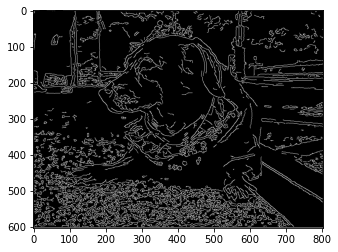

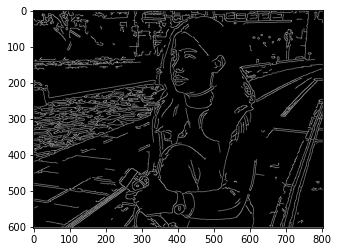

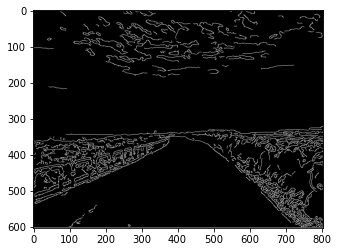

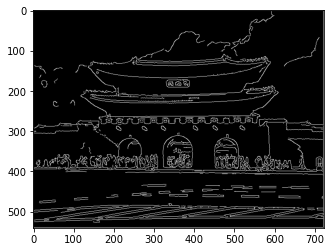

In [17]:
# use canny edge detector in existing library
for i in range(len(img_list)):
    blurred = gaussian_blur(img_list[i], 5, 3)
    canny = cv2.Canny(blurred, 40, 80)
    show_image(canny)
    cv2.imwrite(f'result_images/IMG-{i+1}-cannylib-40-80.jpg', canny)

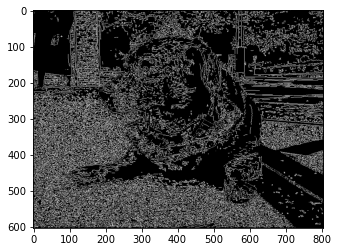

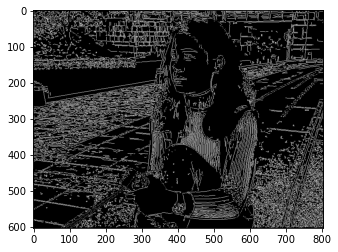

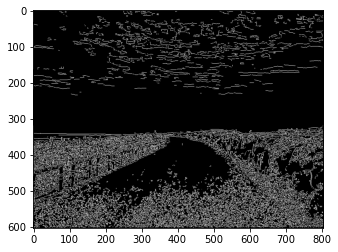

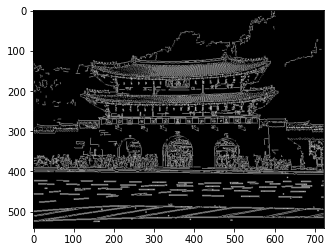

In [13]:
# use canny edge detector for images unblurred
for i in range(len(img_list)):
    canny = canny_edge_detector(img_list[i], 40, 80)
    show_image(canny)
    cv2.imwrite(f'result_images/IMG-{i+1}-canny-unblurred-40-80.jpg', canny)